In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
#import oshttp://localhost:8996/notebooks/inceptionv_keras_vanilla.ipynb#
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [20]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#from keras.utils import multi_gpu_model

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6187725024285852037
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 163381248
locality {
  bus_id: 1
}
incarnation: 4716613740847746846
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:05:00.0, compute capability: 5.2"
]


In [22]:
train_data_dir = "train"
val_data_dir = "test"
img_width = 180
img_height = 180
#classnames = pickle.load(open("/path/to/val/", "rb"))
batch_size = 64   # 258
train_size = 1192270
test_size = 132499

In [23]:
# Data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        shuffle = True,
        class_mode = 'categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        class_mode = 'categorical')

Found 1192270 images belonging to 27 classes.
Found 132499 images belonging to 27 classes.


In [24]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None, input_shape=(img_width, img_height, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

x = Dropout(0.1)(x)

# and a logistic layer -- let's say we have 200 classes

predictions = Dense(27, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
#model = multi_gpu_model(model, gpus=4)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[top_k_categorical_accuracy, 'accuracy'])




In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=0, mode='auto')

filepath="weights_inception.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tbd = TensorBoard(log_dir='./logs_inception',  batch_size=batch_size, write_graph=True )

In [26]:
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                         steps_per_epoch = 7000,
                         epochs = 10,
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = 8,     
                         validation_data = validation_generator,
                         callbacks=[tbd, checkpoint, earlystop ],
                         validation_steps = math.ceil(test_size  / batch_size))
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/10
7000/7000 [==============================] - 2756s 394ms/step - loss: 1.9347 - top_k_categorical_accuracy: 0.7611 - acc: 0.4468 - val_loss: 1.6996 - val_top_k_categorical_accuracy: 0.8056 - val_acc: 0.5131
Epoch 2/10
7000/7000 [==============================] - 3017s 431ms/step - loss: 1.7567 - top_k_categorical_accuracy: 0.7938 - acc: 0.4967 - val_loss: 1.6234 - val_top_k_categorical_accuracy: 0.8152 - val_acc: 0.5369
Epoch 3/10
7000/7000 [==============================] - 2997s 428ms/step - loss: 1.6931 - top_k_categorical_accuracy: 0.8044 - acc: 0.5135 - val_loss: 1.5915 - val_top_k_categorical_accuracy: 0.8234 - val_acc: 0.5465
Epoch 4/10
7000/7000 [==============================] - 2215s 316ms/step - loss: 1.6542 - top_k_categorical_accuracy: 0.8101 - acc: 0.5264 - val_loss: 1.5436 - val_top_k_categorical_accuracy: 0.8293 - val_acc: 0.5583
Epoch 5/10
7000/7000 [==============================] - 2425s 346ms/step - loss: 1.6389 - top_k_categorical_accuracy: 0.8132 - acc: 

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc'])


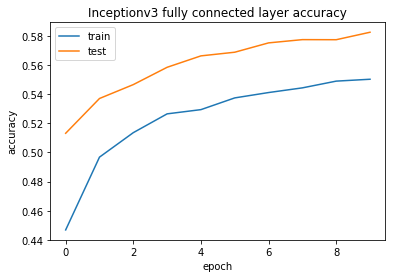

In [27]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Inceptionv3 fully connected layer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True


0 input_3
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

In [29]:
model.save_weights('model_wpart_inception.h5') 

In [30]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), 
              metrics=[top_k_categorical_accuracy, 'accuracy'])
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit_generator(generator=train_generator,
                         steps_per_epoch = 7000,
                         epochs = 25,
                         initial_epoch=10,
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = 16,                                  
                         validation_data = validation_generator,
                         callbacks=[tbd, checkpoint, earlystop, reduce_lr ],
                         validation_steps = math.ceil(test_size / batch_size))

Epoch 11/25
7000/7000 [==============================] - 2469s 353ms/step - loss: 1.3841 - top_k_categorical_accuracy: 0.8562 - acc: 0.6019 - val_loss: 1.2088 - val_top_k_categorical_accuracy: 0.8824 - val_acc: 0.6532
Epoch 12/25
7000/7000 [==============================] - 2470s 353ms/step - loss: 1.2530 - top_k_categorical_accuracy: 0.8758 - acc: 0.6379 - val_loss: 1.1170 - val_top_k_categorical_accuracy: 0.8933 - val_acc: 0.6782
Epoch 13/25
7000/7000 [==============================] - 2473s 353ms/step - loss: 1.1710 - top_k_categorical_accuracy: 0.8870 - acc: 0.6617 - val_loss: 1.0693 - val_top_k_categorical_accuracy: 0.8997 - val_acc: 0.6941
Epoch 14/25
7000/7000 [==============================] - 2468s 353ms/step - loss: 1.1067 - top_k_categorical_accuracy: 0.8966 - acc: 0.6784 - val_loss: 1.0347 - val_top_k_categorical_accuracy: 0.9037 - val_acc: 0.7042
Epoch 15/25
7000/7000 [==============================] - 2473s 353ms/step - loss: 1.0806 - top_k_categorical_accuracy: 0.9005 - 

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc', 'lr'])


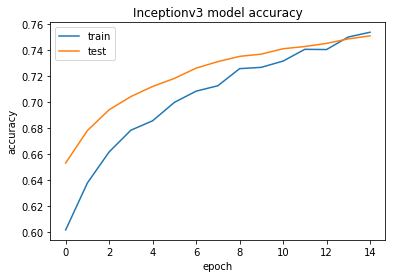

In [31]:
print(history1.history.keys())
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Inceptionv3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.save_weights('model_inception_wfull.h5') 